In [14]:
import uproot
import uproot_methods
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import PolynomialModel, GaussianModel, DoniachModel, ExponentialGaussianModel, VoigtModel
import matplotlib.patches as mpatches  # for "Total SM & uncertainty" merged legend handle
from matplotlib.lines import Line2D  # for dashed line in legend
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, LogLocator, LogFormatterSciNotation  # for minor ticks
import scipy.stats
import os

import ZBosonSamples
import ZBosonCuts
import ZBosonHistograms
import infofile

In [16]:
class CustomTicker(LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        if x not in [1, 10]:
            return LogFormatterSciNotation.__call__(self, x, pos=None)
        else:
            return "{x:g}".format(x=x)
        
def mychisqr(resids,heights):
    errors = np.sqrt(heights).astype(int)
    errors[errors == 0] = 1 #should actually use Poisson errors below N~10
    return np.sum(np.square(resids/errors))


In [17]:
stack_order = ['single top', 'W+jets', 'ttbar', 'Diboson']  # put smallest contribution first, then increase

In [4]:
def make_plots(fraction):

    lumi = 10  # 10 fb-1 for data_A,B,C,D
    lumi_used = lumi * fraction

    signal_format = 'hist'  # 'line' or 'hist' or None
    Total_SM_label = False  # for Total SM black line in plot and legend
    plot_label = r'$Z \rightarrow ll$'
    signal_label = plot_label

    # find the dignal (it's the one not in the stack order)
    signal = None
    for s in ZBosonSamples.samples.keys():
        if s not in stack_order and s != 'data': signal = s

    for x_variable, hist in ZBosonHistograms.hist_dict.items():

        h_bin_width = hist['bin_width']
        h_num_bins = hist['num_bins']
        h_xrange_min = hist['xrange_min']
        h_xlabel = hist['xlabel']
        h_log_y = hist['log_y']
        h_y_label_x_position = hist['y_label_x_position']
        h_legend_loc = hist['legend_loc']
        h_log_top_margin = hist[
            'log_top_margin']  # to decrease the separation between data and the top of the figure, remove a 0
        h_linear_top_margin = hist[
            'linear_top_margin']  # to decrease the separation between data and the top of the figure, pick a number closer to 1

        bins = [h_xrange_min + x * h_bin_width for x in range(h_num_bins + 1)]
        bin_centres = [h_xrange_min + h_bin_width / 2 + x * h_bin_width for x in range(h_num_bins)]

        npzfile = np.load(f'histograms/{x_variable}_hist_{fraction}.npz')
        # load bins
        loaded_bins = npzfile['bins']
        if not np.array_equal(bins, loaded_bins):
            print('Bins mismatch. That\'s a problem')
            raise Exception

        # load data
        data_x = npzfile['data']
        data_x_errors = np.sqrt(data_x)
        # load weighted signal
        signal_x_reshaped = npzfile[signal]
        signal_color = ZBosonSamples.samples[signal]['color']
        # load backgrounds
        mc_x_heights_list = []
        # mc_weights = []
        mc_colors = []
        mc_labels = []
        mc_x_tot = np.zeros(len(bin_centres))
        for s in stack_order:
            if not s in npzfile: continue
            mc_labels.append(s)
            # mc_x.append(data[s][x_variable].values)
            mc_colors.append(ZBosonSamples.samples[s]['color'])
            # mc_weights.append(data[s].totalWeight.values)
            mc_x_heights = npzfile[s]
            mc_x_heights_list.append(mc_x_heights)
            mc_x_tot = np.add(mc_x_tot, mc_x_heights)
        mc_x_err = np.sqrt(mc_x_tot)

        # subtract background from data
        data_x_without_bkg = data_x - mc_x_tot

        # data fit

        # get rid of zero errors (maybe messy) : TODO a better way to do this?
        for i, e in enumerate(data_x_errors):
            if e == 0: data_x_errors[i] = np.inf
        if 0 in data_x_errors:
            print('please don\'t divide by zero')
            raise Exception

        bin_centres_array = np.asarray(bin_centres)

        # *************
        # Models
        # *************

        doniach_mod = DoniachModel()
        pars_doniach = doniach_mod.guess(data_x_without_bkg, x=bin_centres_array, amplitude=2100000 * fraction, center=90.5, sigma=2.3, height=10000 * fraction / 0.01, gamma=0)
        doniach = doniach_mod.fit(data_x_without_bkg, pars_doniach, x=bin_centres_array, weights=1 / data_x_errors)
        params_dict_doniach = doniach.params.valuesdict()


        gaussian_mod = GaussianModel()
        pars_gaussian = gaussian_mod.guess(data_x_without_bkg, x=bin_centres_array, amplitude=6000000*fraction, center=90.5, sigma=3)
        gaussian = gaussian_mod.fit(data_x_without_bkg, pars_gaussian, x=bin_centres_array, weights=1 / data_x_errors)
        params_dict_gaussian = gaussian.params.valuesdict()


        exponential_gaussian_mod = ExponentialGaussianModel()
        pars = exponential_gaussian_mod.guess(data_x_without_bkg, x=bin_centres_array, amplitude=6000000*fraction, center = 90.5, sigma=2.9, gamma = 1)
        exp_gaussian = exponential_gaussian_mod.fit(data_x_without_bkg, pars, x=bin_centres_array, weights=1 / data_x_errors)
        params_dict_exp_gaussian = exp_gaussian.params.valuesdict()


        voigt_mod = VoigtModel()
        pars = voigt_mod.guess(data_x_without_bkg, x=bin_centres_array, amplitude=6800000*fraction, center=90.5, sigma=1.7)
        voigt = voigt_mod.fit(data_x_without_bkg, pars, x=bin_centres_array, weights=1 / data_x_errors)
        params_dict_voigt = voigt.params.valuesdict()



        # *************
        # Main plot
        # *************
        plt.clf()
        plt.figure(figsize=[10,8])
        plt.axes([0.1, 0.3, 0.85, 0.65], )  # (left, bottom, width, height)
        main_axes = plt.gca()
        main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label='Data')
        # this effectively makes a stacked histogram
        bottoms = np.zeros_like(bin_centres)
        for mc_x_height, mc_color, mc_label in zip(mc_x_heights_list, mc_colors, mc_labels) :
            main_axes.bar(bin_centres, mc_x_height, bottom=bottoms, color=mc_color, label=mc_label, width=h_bin_width*1.01)
            bottoms = np.add(bottoms, mc_x_height)


        main_axes.plot(bin_centres, doniach.best_fit, '-r', label='Doniach')
        main_axes.plot(bin_centres, gaussian.best_fit, '-g', label='Gaussian')
        main_axes.plot(bin_centres, exp_gaussian.best_fit, '-y', label='Exponential Gaussian')
        main_axes.plot(bin_centres, voigt.best_fit, '--', label='Voigt')

        if Total_SM_label:
            totalSM_handle, = main_axes.step(bins, np.insert(mc_x_tot, 0, mc_x_tot[0]), color='black')
        if signal_format == 'line':
            main_axes.step(bins, np.insert(signal_x, 0, signal_x[0]), color=ZBosonSamples.samples[signal]['color'],
                           linestyle='--',
                           label=signal)
        elif signal_format == 'hist':
            main_axes.bar(bin_centres, signal_x_reshaped, bottom=bottoms, color=signal_color, label=signal,
                          width=h_bin_width*1.01)
            bottoms = np.add(bottoms, signal_x_reshaped)
        main_axes.bar(bin_centres, 2 * mc_x_err, bottom=bottoms - mc_x_err, alpha=0.5, color='none', hatch="////",
                      width=h_bin_width*1.01, label='Stat. Unc.')

        mc_x_tot = bottoms

        main_axes.set_xlim(left=h_xrange_min, right=bins[-1])
        main_axes.xaxis.set_minor_locator(AutoMinorLocator())  # separation of x axis minor ticks
        main_axes.tick_params(which='both', direction='in', top=True, labeltop=False, labelbottom=False, right=True,
                              labelright=False)

        if h_log_y:
            main_axes.set_yscale('log')
            smallest_contribution = mc_x_heights_list[0] # TODO: mc_heights or mc_x_heights
            smallest_contribution.sort()
            bottom = smallest_contribution[-2]
            if bottom == 0: bottom = 0.001 # log doesn't like zero
            top = np.amax(data_x) * h_log_top_margin
            main_axes.set_ylim(bottom=bottom, top=top)
            main_axes.yaxis.set_major_formatter(CustomTicker())
            locmin = LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=12)
            main_axes.yaxis.set_minor_locator(locmin)
        else:
            main_axes.set_ylim(bottom=0, top=(np.amax(data_x) + math.sqrt(np.amax(data_x))) * h_linear_top_margin)
            main_axes.yaxis.set_minor_locator(AutoMinorLocator())
            main_axes.yaxis.get_major_ticks()[0].set_visible(False)

        plt.text(0.015, 0.97, 'ATLAS Open Data', ha="left", va="top", family='sans-serif', transform=main_axes.transAxes,
                 fontsize=13)
        plt.text(0.015, 0.9, 'for education', ha="left", va="top", family='sans-serif', transform=main_axes.transAxes,
                 style='italic', fontsize=8)
        plt.text(0.015, 0.86, r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=$' + str(lumi_used) + '$\,\mathrm{fb}^{-1}$',
                 ha="left", va="top", family='sans-serif', transform=main_axes.transAxes)
        plt.text(0.015, 0.78, plot_label, ha="left", va="top", family='sans-serif', transform=main_axes.transAxes)
        plt.text(0.015, 0.72, r'$m_Z = $' + str(round(params_dict_doniach['center'], 4)) + ' GeV', ha="left", va="top", family='sans-serif', transform=main_axes.transAxes,
                 fontsize=10)

        # Create new legend handles but use the colors from the existing ones
        handles, labels = main_axes.get_legend_handles_labels()
        if signal_format == 'line':
            handles[labels.index(signal)] = Line2D([], [], c=ZBosonSamples.samples[signal]['color'], linestyle='dashed')
        uncertainty_handle = mpatches.Patch(facecolor='none', hatch='////')
        if Total_SM_label:
            handles.append((totalSM_handle, uncertainty_handle))
            labels.append('Total SM')
        else:
            handles.append(uncertainty_handle)
            labels.append('Stat. Unc.')

        # specify order within legend
        new_handles = [handles[labels.index('Data')],
                       handles[labels.index('Doniach')],
                       handles[labels.index('Gaussian')],
                       handles[labels.index('Exponential Gaussian')],
                       handles[labels.index('Voigt')]]
        new_labels = ['Data', 'Doniach', 'Gaussian', 'Exponential Gaussian', 'Voigt']
        for s in reversed(stack_order):
            if s not in labels:
                continue
            new_handles.append(handles[labels.index(s)])
            new_labels.append(s)
        if signal is not None:
            new_handles.append(handles[labels.index(signal)])
            new_labels.append(signal_label)
        if Total_SM_label:
            new_handles.append(handles[labels.index('Total SM')])
            new_labels.append('Total SM')
        else:
            new_handles.append(handles[labels.index('Stat. Unc.')])
            new_labels.append('Stat. Unc.')
        main_axes.legend(handles=new_handles, labels=new_labels, frameon=False, loc=h_legend_loc, fontsize='x-small')


        # *************
        # Data / MC plot
        # *************


        plt.axes([0.1, 0.1, 0.85, 0.2])  # (left, bottom, width, height)
        ratio_axes = plt.gca()
        ratio_axes.yaxis.set_major_locator(MaxNLocator(nbins='auto', symmetric=True))
        ratio_axes.errorbar(x=bin_centres, y=data_x / signal_x_reshaped, fmt='ko') # TODO: yerr=data_x_errors produce error bars that are too big
        ratio_axes.set_xlim(left=h_xrange_min, right=bins[-1])
        ratio_axes.plot(bins, np.ones(len(bins)), color='k')
        ratio_axes.xaxis.set_minor_locator(AutoMinorLocator())  # separation of x axis minor ticks
        ratio_axes.xaxis.set_label_coords(0.9, -0.2)  # (x,y) of x axis label # 0.2 down from x axis
        ratio_axes.set_xlabel(h_xlabel, fontname='sans-serif', fontsize=11)
        ratio_axes.set_ylim(bottom=0, top=2)
        ratio_axes.set_yticks([0, 1])
        ratio_axes.tick_params(which='both', direction='in', top=True, labeltop=False, right=True, labelright=False)
        ratio_axes.yaxis.set_minor_locator(AutoMinorLocator())
        ratio_axes.set_ylabel(r'Data / Pred', fontname='sans-serif', x=1, fontsize=11)


        # Generic features for both plots
        main_axes.yaxis.set_label_coords(h_y_label_x_position, 1)
        ratio_axes.yaxis.set_label_coords(h_y_label_x_position, 0.5)

        plt.savefig("ZBoson_" + x_variable + ".pdf", bbox_inches='tight')
        plt.savefig("ZBoson_" + x_variable + str(fraction) + ".png", bbox_inches='tight')
        plt.show()

        # ========== Statistics ==========

        # ========== Doniach ==========
        chisqr_doniach = mychisqr(doniach.residual, doniach.best_fit)
        redchisqr_doniach = chisqr_doniach/doniach.nfree
        center_doniach = params_dict_doniach['center']
        sigma_doniach = params_dict_doniach['sigma']

        rel_unc_center_doniach = doniach.params['center'].stderr / doniach.params['center'].value
        rel_unc_sigma_doniach = doniach.params['sigma'].stderr / doniach.params['sigma'].value


        # ========== Gaussian ==========
        chisqr_gaussian = mychisqr(gaussian.residual, gaussian.best_fit)
        redchisqr_gaussian = chisqr_gaussian / gaussian.nfree
        center_gaussian = params_dict_gaussian['center']
        sigma_gaussian = params_dict_gaussian['sigma']

        rel_unc_center_gaussian = gaussian.params['center'].stderr / gaussian.params['center'].value
        rel_unc_sigma_gaussian = gaussian.params['sigma'].stderr / gaussian.params['sigma'].value

        # ========== Exponential Gaussian ==========
        chisqr_exp_gaussian = mychisqr(exp_gaussian.residual, exp_gaussian.best_fit)
        redchisqr_exp_gaussian = chisqr_exp_gaussian / exp_gaussian.nfree
        center_exp_gaussian = params_dict_exp_gaussian['center']
        sigma_exp_gaussian = params_dict_exp_gaussian['sigma']

        rel_unc_center_exp_gaussian = exp_gaussian.params['center'].stderr / exp_gaussian.params['center'].value
        rel_unc_sigma_exp_gaussian = exp_gaussian.params['sigma'].stderr / exp_gaussian.params['sigma'].value

        # ========== Voigt ==========
        chisqr_voigt = mychisqr(voigt.residual, voigt.best_fit)
        redchisqr_voigt = chisqr_voigt / voigt.nfree
        center_voigt = params_dict_voigt['center']
        sigma_voigt = params_dict_voigt['sigma']

        rel_unc_center_voigt = voigt.params['center'].stderr / voigt.params['center'].value
        rel_unc_sigma_voigt = voigt.params['sigma'].stderr / voigt.params['sigma'].value


        df_dict = {'fraction':[fraction],
                   'luminosity':[lumi_used],
                   'doniach chisqr':[chisqr_doniach],
                   'doniach redchisqr':[redchisqr_doniach],
                   'doniach center': [rel_unc_center_doniach],
                   'doniach sigma': [rel_unc_sigma_doniach],
                   'gaussian chisqr':[chisqr_gaussian],
                   'gaussian redchisqr':[redchisqr_gaussian],
                   'gaussian center': [rel_unc_center_gaussian],
                   'gaussian sigma': [rel_unc_sigma_gaussian],
                   'exponential gaussian chisqr':[chisqr_exp_gaussian],
                   'exponential gaussian redchisqr':[redchisqr_exp_gaussian],
                   'exponential gaussian center': [rel_unc_center_exp_gaussian],
                   'exponential gaussian sigma': [rel_unc_sigma_exp_gaussian],
                   'voigt chisqr':[chisqr_voigt],
                   'voigt redchisqr':[redchisqr_voigt],
                   'voigt center': [rel_unc_center_voigt],
                   'voigt sigma': [rel_unc_sigma_voigt]}

        temp = pd.DataFrame(df_dict)

        # fit_results = pd.read_csv('fit_results.csv')
        #
        # fit_results_concat = pd.concat([fit_results, temp])
        #
        # fit_results_concat.to_csv('fit_results.csv', index = False)


        print("=====================================================")
        print("Statistics for the Doniach Model: ")
        print("\n")
        print("chi^2 = " + str(chisqr_doniach))
        print("chi^2/dof = " + str(redchisqr_doniach))
        print("center = " + str(center_doniach))
        print("sigma = " + str(sigma_doniach))
        print("Relative Uncertainty of Center = " + str(rel_unc_center_doniach))
        print("Relative Uncertainty of Sigma = " + str(rel_unc_sigma_doniach))

        print("\n")
        print("=====================================================")
        print("Statistics for the Gaussian Model: ")
        print("\n")
        print("chi^2 = " + str(chisqr_gaussian))
        print("chi^2/dof = " + str(redchisqr_gaussian))
        print("center = " + str(center_gaussian))
        print("sigma = " + str(sigma_gaussian))
        print("Relative Uncertainty of Center = " + str(rel_unc_center_gaussian))
        print("Relative Uncertainty of Sigma = " + str(rel_unc_sigma_gaussian))

        print("\n")
        print("=====================================================")
        print("Statistics for the Exponential Gaussian Model: ")
        print("\n")
        print("chi^2 = " + str(chisqr_exp_gaussian))
        print("chi^2/dof = " + str(redchisqr_exp_gaussian))
        print("center = " + str(center_exp_gaussian))
        print("sigma = " + str(sigma_exp_gaussian))
        print("Relative Uncertainty of Center = " + str(rel_unc_center_exp_gaussian))
        print("Relative Uncertainty of Sigma = " + str(rel_unc_sigma_exp_gaussian))

        print("\n")
        print("=====================================================")
        print("Statistics for the Voigt Model: ")
        print("\n")
        print("chi^2 = " + str(chisqr_voigt))
        print("chi^2/dof = " + str(redchisqr_voigt))
        print("center = " + str(center_voigt))
        print("sigma = " + str(sigma_voigt))
        print("Relative Uncertainty of Center = " + str(rel_unc_center_voigt))
        print("Relative Uncertainty of Sigma = " + str(rel_unc_sigma_voigt))

        # ========= Plotting Residuals =========

        # ========= Doniach Residuals =========

        plt.clf()
        plt.axes([0.1, 0.3, 0.85, 0.65])  # (left, bottom, width, height)
        main_axes = plt.gca()

        main_axes.set_title("Doniach Model Residuals")

        main_axes.errorbar(x=bin_centres, y=doniach.residual, fmt='ko')

        main_axes.set_xlim(left=h_xrange_min, right=bins[-1])
        main_axes.xaxis.set_minor_locator(AutoMinorLocator())  # separation of x axis minor ticks
        main_axes.tick_params(which='both', direction='in', top=True, labeltop=False, right=True,
                              labelright=False)

        main_axes.set_xlabel(r'$M_Z$ GeV')
        main_axes.xaxis.get_major_ticks()[0].set_visible(False)

        main_axes.set_ylim(bottom=1.05*doniach.residual.min(), top=1.05*doniach.residual.max())
        main_axes.yaxis.set_minor_locator(AutoMinorLocator())
        main_axes.yaxis.get_major_ticks()[0].set_visible(False)
        main_axes.set_ylabel("Residual")

        plt.savefig("plots/doniach_residuals.pdf", bbox_inches='tight')

        # ========= Gaussian Residuals =========

        plt.clf()
        plt.axes([0.1, 0.3, 0.85, 0.65])  # (left, bottom, width, height)
        main_axes = plt.gca()

        main_axes.set_title("Gaussian Model Residuals")

        main_axes.errorbar(x=bin_centres, y=gaussian.residual, fmt='ko')

        main_axes.set_xlim(left=h_xrange_min, right=bins[-1])
        main_axes.xaxis.set_minor_locator(AutoMinorLocator())  # separation of x axis minor ticks
        main_axes.tick_params(which='both', direction='in', top=True, labeltop=False, right=True,
                              labelright=False)

        main_axes.set_xlabel(r'$M_Z$ GeV')
        main_axes.xaxis.get_major_ticks()[0].set_visible(False)

        main_axes.set_ylim(bottom=1.05*gaussian.residual.min(), top=1.05*gaussian.residual.max())
        main_axes.yaxis.set_minor_locator(AutoMinorLocator())
        main_axes.yaxis.get_major_ticks()[0].set_visible(False)
        main_axes.set_ylabel("Residual")

        plt.savefig("plots/gaussian_residuals.pdf", bbox_inches='tight')

        # ========= Exponential Gaussian Residuals =========

        plt.clf()
        plt.axes([0.1, 0.3, 0.85, 0.65])  # (left, bottom, width, height)
        main_axes = plt.gca()

        main_axes.set_title("Exponential Gaussian Model Residuals")

        main_axes.errorbar(x=bin_centres, y=exp_gaussian.residual, fmt='ko')

        main_axes.set_xlim(left=h_xrange_min, right=bins[-1])
        main_axes.xaxis.set_minor_locator(AutoMinorLocator())  # separation of x axis minor ticks
        main_axes.tick_params(which='both', direction='in', top=True, labeltop=False, right=True,
                              labelright=False)

        main_axes.set_xlabel(r'$M_Z$ GeV')
        main_axes.xaxis.get_major_ticks()[0].set_visible(False)

        main_axes.set_ylim(bottom=1.05*exp_gaussian.residual.min(), top=1.05*exp_gaussian.residual.max())
        main_axes.yaxis.set_minor_locator(AutoMinorLocator())
        main_axes.yaxis.get_major_ticks()[0].set_visible(False)
        main_axes.set_ylabel("Residual")

        plt.savefig("plots/exp_gaussian_residuals.pdf", bbox_inches='tight')
        
        # ========= Voigt Residuals =========

        plt.clf()
        plt.axes([0.1, 0.3, 0.85, 0.65])  # (left, bottom, width, height)
        main_axes = plt.gca()

        main_axes.set_title("Voigt Model Residuals")

        main_axes.errorbar(x=bin_centres, y=voigt.residual, fmt='ko')

        main_axes.set_xlim(left=h_xrange_min, right=bins[-1])
        main_axes.xaxis.set_minor_locator(AutoMinorLocator())  # separation of x axis minor ticks
        main_axes.tick_params(which='both', direction='in', top=True, labeltop=False, right=True,
                              labelright=False)

        main_axes.set_xlabel(r'$M_Z$ GeV')
        main_axes.xaxis.get_major_ticks()[0].set_visible(False)

        main_axes.set_ylim(bottom=1.05*voigt.residual.min(), top=1.05*voigt.residual.max())
        main_axes.yaxis.set_minor_locator(AutoMinorLocator())
        main_axes.yaxis.get_major_ticks()[0].set_visible(False)
        main_axes.set_ylabel("Residual")

        plt.savefig("plots/voigt_residuals.pdf", bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

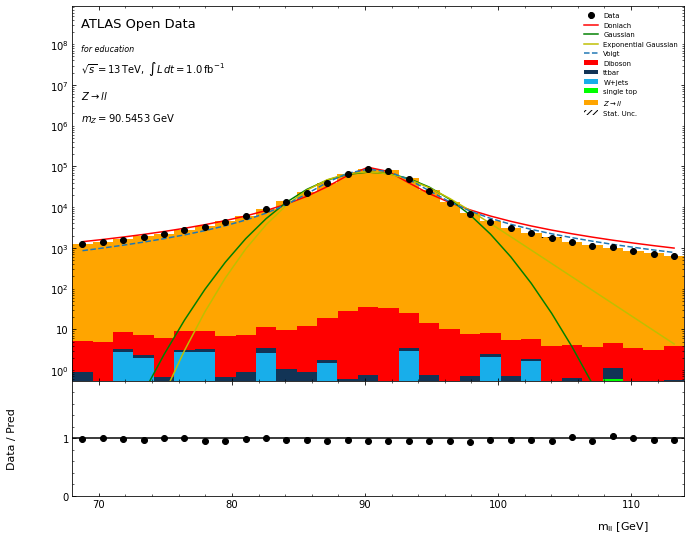

Statistics for the Doniach Model: 


chi^2 = 2.3668399259122466
chi^2/dof = 0.09103230484277872
center = 90.54529192848385
sigma = 2.290340782478769
Relative Uncertainty of Center = 0.001379625543035098
Relative Uncertainty of Sigma = 0.055453428755154466


Statistics for the Gaussian Model: 


chi^2 = 14333.757378427474
chi^2/dof = 530.8799029047212
center = 90.39513080145788
sigma = 3.4131852917572374
Relative Uncertainty of Center = 0.00238685731235392
Relative Uncertainty of Sigma = 0.05339734195370956


Statistics for the Exponential Gaussian Model: 


chi^2 = 11526.56296548881
chi^2/dof = 443.32934482649273
center = 88.59008764226256
sigma = 2.8895053415100342
Relative Uncertainty of Center = 0.006325982585404897
Relative Uncertainty of Sigma = 0.11823797745586379


Statistics for the Voigt Model: 


chi^2 = 1.3845381795387979
chi^2/dof = 0.05127919183477029
center = 90.43607991190379
sigma = 1.7433668854176032
Relative Uncertainty of Center = 0.0007271255126313498
Relative Uncer

<Figure size 432x288 with 0 Axes>

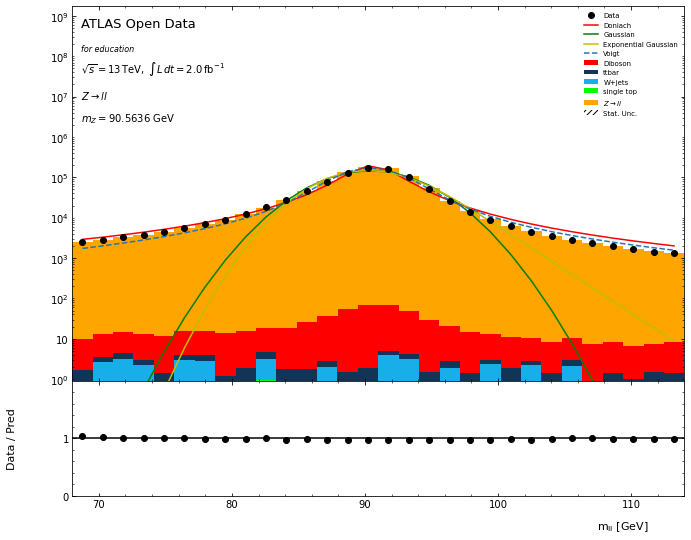

Statistics for the Doniach Model: 


chi^2 = 2.345288766912893
chi^2/dof = 0.09020341411203434
center = 90.56355077413573
sigma = 2.2817675659338414
Relative Uncertainty of Center = 0.0013699998089768048
Relative Uncertainty of Sigma = 0.05536798063226579


Statistics for the Gaussian Model: 


chi^2 = 23277.47154242607
chi^2/dof = 862.1285756454099
center = 90.40870317786849
sigma = 3.4109069313001736
Relative Uncertainty of Center = 0.002391216902972614
Relative Uncertainty of Sigma = 0.05355699036144467


Statistics for the Exponential Gaussian Model: 


chi^2 = 18919.16654317281
chi^2/dof = 727.6602516604927
center = 88.60873014521226
sigma = 2.889077338400163
Relative Uncertainty of Center = 0.006344758830880787
Relative Uncertainty of Sigma = 0.11851369687355236


Statistics for the Voigt Model: 


chi^2 = 1.432279181721791
chi^2/dof = 0.05304737710080708
center = 90.44968046533849
sigma = 1.741074948932853
Relative Uncertainty of Center = 0.0007356458664366282
Relative Uncertain

<Figure size 432x288 with 0 Axes>

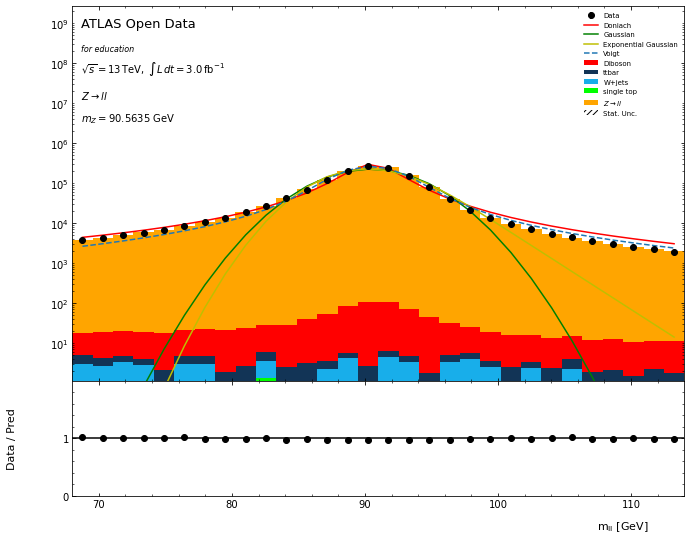

Statistics for the Doniach Model: 


chi^2 = 2.3530865248891555
chi^2/dof = 0.09050332788035213
center = 90.56351883744296
sigma = 2.2807260514383647
Relative Uncertainty of Center = 0.001360510378190715
Relative Uncertainty of Sigma = 0.05505899358420922


Statistics for the Gaussian Model: 


chi^2 = 34083.11581006649
chi^2/dof = 1262.337622595055
center = 90.41113344036083
sigma = 3.407272655110532
Relative Uncertainty of Center = 0.002388435414266122
Relative Uncertainty of Sigma = 0.05356599982033295


Statistics for the Exponential Gaussian Model: 


chi^2 = 27993.003782935633
chi^2/dof = 1076.6539916513705
center = 88.6000616036322
sigma = 2.879045305034738
Relative Uncertainty of Center = 0.006276011106242258
Relative Uncertainty of Sigma = 0.11831202887795879


Statistics for the Voigt Model: 


chi^2 = 1.4099933312180364
chi^2/dof = 0.052221975230297646
center = 90.4512724107737
sigma = 1.7395908763562957
Relative Uncertainty of Center = 0.0007267964845473747
Relative Uncerta

<Figure size 432x288 with 0 Axes>

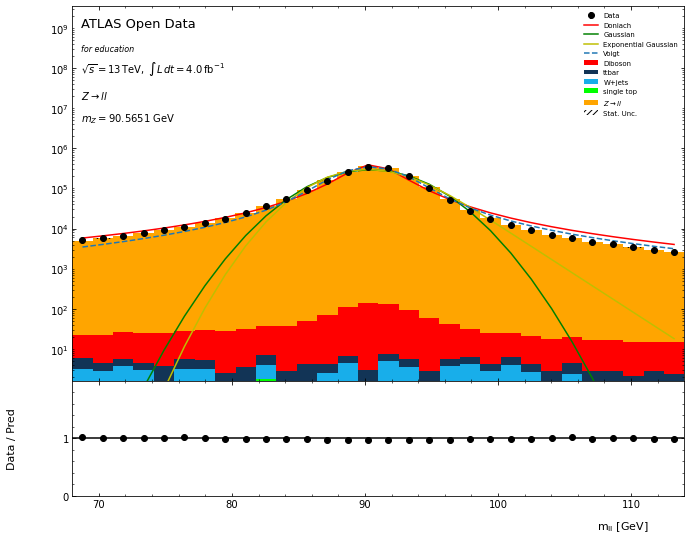

Statistics for the Doniach Model: 


chi^2 = 2.3079041644675673
chi^2/dof = 0.08876554478721413
center = 90.56514953675277
sigma = 2.2802130895774777
Relative Uncertainty of Center = 0.001358870680413751
Relative Uncertainty of Sigma = 0.05503093343991279


Statistics for the Gaussian Model: 


chi^2 = 44211.60066918125
chi^2/dof = 1637.4666914511574
center = 90.41254551613738
sigma = 3.4076000577601055
Relative Uncertainty of Center = 0.002388081814893949
Relative Uncertainty of Sigma = 0.053533246404500266


Statistics for the Exponential Gaussian Model: 


chi^2 = 35490.938571008526
chi^2/dof = 1365.0360988849434
center = 88.60805865062488
sigma = 2.883148207006087
Relative Uncertainty of Center = 0.006307294835240966
Relative Uncertainty of Sigma = 0.1183582371065935


Statistics for the Voigt Model: 


chi^2 = 1.3953054625329886
chi^2/dof = 0.05167798009381439
center = 90.45299761502392
sigma = 1.7394845694674665
Relative Uncertainty of Center = 0.0007278814669592313
Relative Unce

<Figure size 432x288 with 0 Axes>

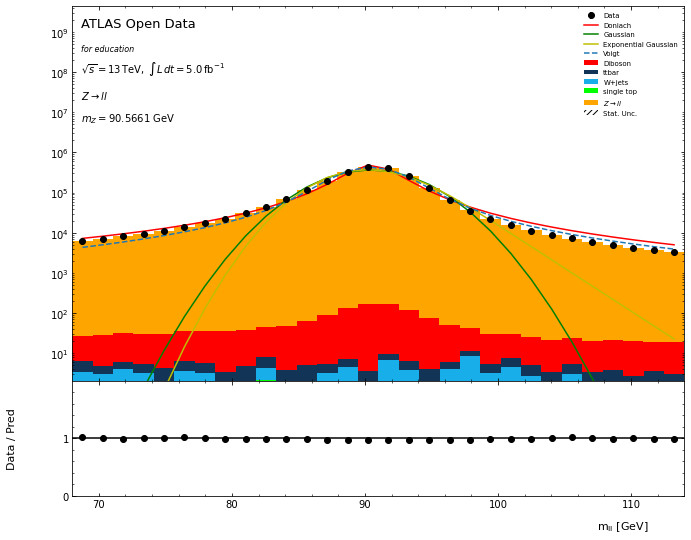

Statistics for the Doniach Model: 


chi^2 = 2.3120643237867156
chi^2/dof = 0.08892555091487367
center = 90.56610637897927
sigma = 2.282078884998734
Relative Uncertainty of Center = 0.0013585150473974042
Relative Uncertainty of Sigma = 0.05498566039810523


Statistics for the Gaussian Model: 


chi^2 = 54647.259421429975
chi^2/dof = 2023.972571164073
center = 90.41262293020672
sigma = 3.4093954584659114
Relative Uncertainty of Center = 0.0023900286556436355
Relative Uncertainty of Sigma = 0.05355102728550689


Statistics for the Exponential Gaussian Model: 


chi^2 = 44200.834513736765
chi^2/dof = 1700.0320966821832
center = 88.60598917510444
sigma = 2.8844294622553606
Relative Uncertainty of Center = 0.006310707907676602
Relative Uncertainty of Sigma = 0.11839851444156485


Statistics for the Voigt Model: 


chi^2 = 1.391713800951473
chi^2/dof = 0.05154495559079529
center = 90.4534219079939
sigma = 1.7408767335877493
Relative Uncertainty of Center = 0.0007281861627002753
Relative Unce

<Figure size 432x288 with 0 Axes>

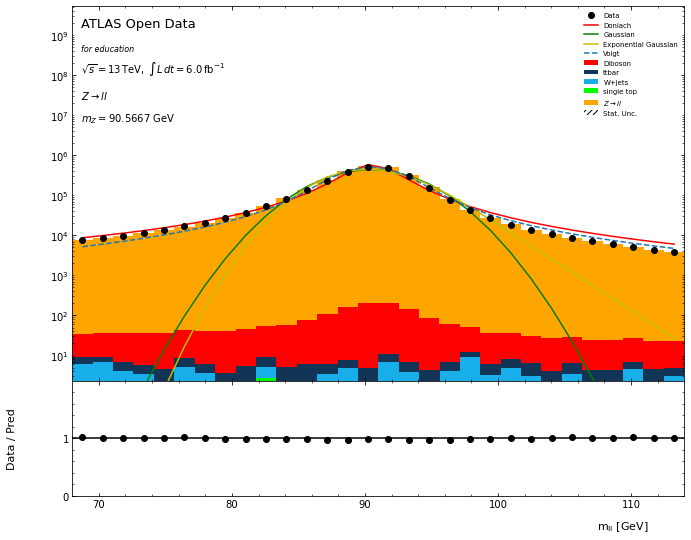

Statistics for the Doniach Model: 


chi^2 = 2.291367571851527
chi^2/dof = 0.0881295219942895
center = 90.56671415405505
sigma = 2.2794356958057915
Relative Uncertainty of Center = 0.0013544569598904195
Relative Uncertainty of Sigma = 0.05488818384398243


Statistics for the Gaussian Model: 


chi^2 = 65848.12528160313
chi^2/dof = 2438.8194548741903
center = 90.41322813615854
sigma = 3.4052359208260707
Relative Uncertainty of Center = 0.0023904838751351992
Relative Uncertainty of Sigma = 0.053654018044432567


Statistics for the Exponential Gaussian Model: 


chi^2 = 52270.77688211922
chi^2/dof = 2010.414495466124
center = 88.60596312252932
sigma = 2.8788501005169724
Relative Uncertainty of Center = 0.006295173398939706
Relative Uncertainty of Sigma = 0.11856789524387507


Statistics for the Voigt Model: 


chi^2 = 1.3849454664856138
chi^2/dof = 0.051294276536504216
center = 90.45421084841104
sigma = 1.738613343606246
Relative Uncertainty of Center = 0.0007269184706471669
Relative Unce

<Figure size 432x288 with 0 Axes>

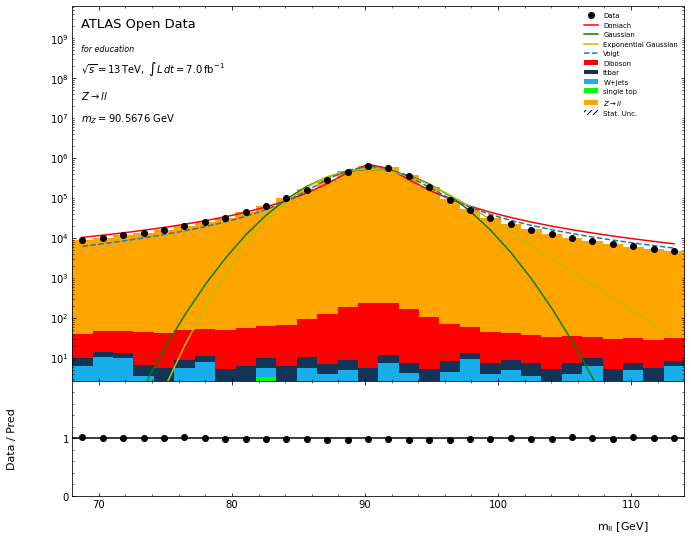

Statistics for the Doniach Model: 


chi^2 = 2.3071121170713553
chi^2/dof = 0.08873508142582136
center = 90.56758442775353
sigma = 2.2794081793781213
Relative Uncertainty of Center = 0.0013543927908581008
Relative Uncertainty of Sigma = 0.054894956990017084


Statistics for the Gaussian Model: 


chi^2 = 75738.0352259523
chi^2/dof = 2805.1124157760114
center = 90.4131996982273
sigma = 3.4052857414239632
Relative Uncertainty of Center = 0.002390897752443092
Relative Uncertainty of Sigma = 0.05366818539482963


Statistics for the Exponential Gaussian Model: 


chi^2 = 60945.009748553646
chi^2/dof = 2344.0388364828327
center = 88.60411763337109
sigma = 2.878129401620287
Relative Uncertainty of Center = 0.0062893406126646465
Relative Uncertainty of Sigma = 0.11856813627680277


Statistics for the Voigt Model: 


chi^2 = 1.3842210136912085
chi^2/dof = 0.05126744495152624
center = 90.45455521354916
sigma = 1.7387573907653477
Relative Uncertainty of Center = 0.0007271163100576546
Relative Unc

<Figure size 432x288 with 0 Axes>

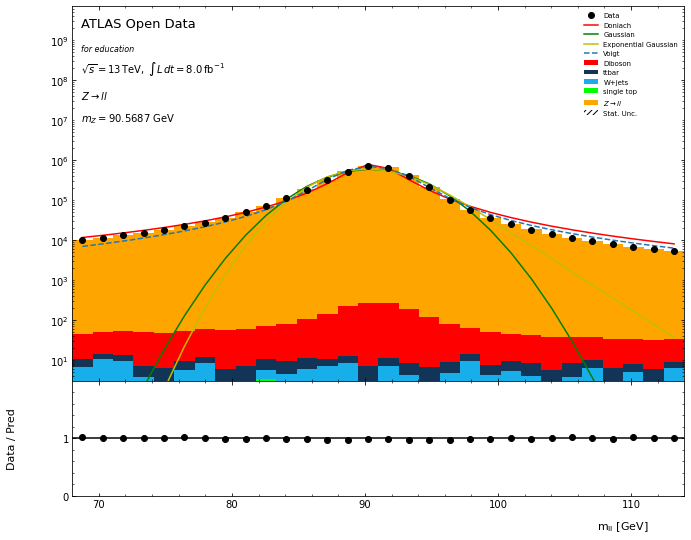

Statistics for the Doniach Model: 


chi^2 = 2.2903345778310036
chi^2/dof = 0.0880897914550386
center = 90.56870330038008
sigma = 2.2794957126234325
Relative Uncertainty of Center = 0.00135355917413945
Relative Uncertainty of Sigma = 0.05487072398122475


Statistics for the Gaussian Model: 


chi^2 = 86495.13538743378
chi^2/dof = 3203.5235328679178
center = 90.4145699538417
sigma = 3.403894721636788
Relative Uncertainty of Center = 0.0023908746583419516
Relative Uncertainty of Sigma = 0.053691485152355105


Statistics for the Exponential Gaussian Model: 


chi^2 = 69492.95416746134
chi^2/dof = 2672.805929517744
center = 88.6062637183374
sigma = 2.877090516746303
Relative Uncertainty of Center = 0.006291959296051354
Relative Uncertainty of Sigma = 0.1186470469074155


Statistics for the Voigt Model: 


chi^2 = 1.3757012143546143
chi^2/dof = 0.05095189682794868
center = 90.45614376696847
sigma = 1.7383373507715731
Relative Uncertainty of Center = 0.0007263804534135875
Relative Uncertaint

<Figure size 432x288 with 0 Axes>

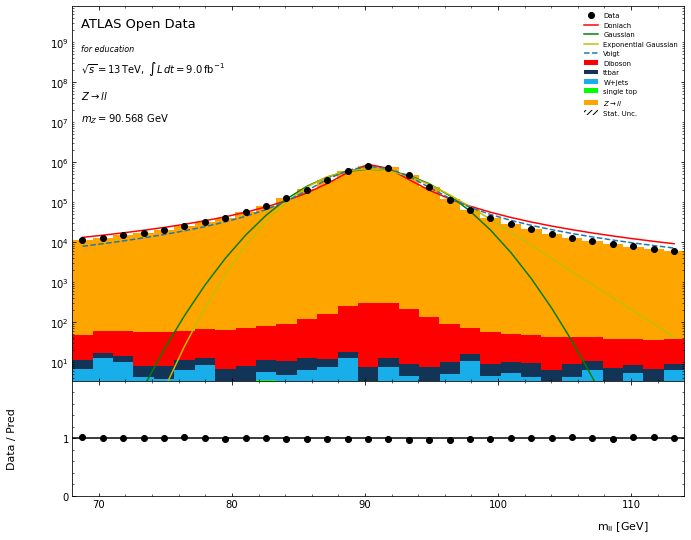

Statistics for the Doniach Model: 


chi^2 = 2.294044070554362
chi^2/dof = 0.08823246425209084
center = 90.567983466201
sigma = 2.2800640196195543
Relative Uncertainty of Center = 0.0013550575883223219
Relative Uncertainty of Sigma = 0.0549067433995627


Statistics for the Gaussian Model: 


chi^2 = 89423.3988067163
chi^2/dof = 3311.9777335820854
center = 90.41530171993422
sigma = 3.403545499553534
Relative Uncertainty of Center = 0.002389722733681857
Relative Uncertainty of Sigma = 0.05367445115930407


Statistics for the Exponential Gaussian Model: 


chi^2 = 78195.40202020892
chi^2/dof = 3007.5154623157277
center = 88.60472970803814
sigma = 2.8753021008394692
Relative Uncertainty of Center = 0.006275705367159226
Relative Uncertainty of Sigma = 0.11855731889490359


Statistics for the Voigt Model: 


chi^2 = 1.3735653325676893
chi^2/dof = 0.0508727900950996
center = 90.45626349793531
sigma = 1.7383152593169129
Relative Uncertainty of Center = 0.0007249342606272362
Relative Uncertaint

<Figure size 432x288 with 0 Axes>

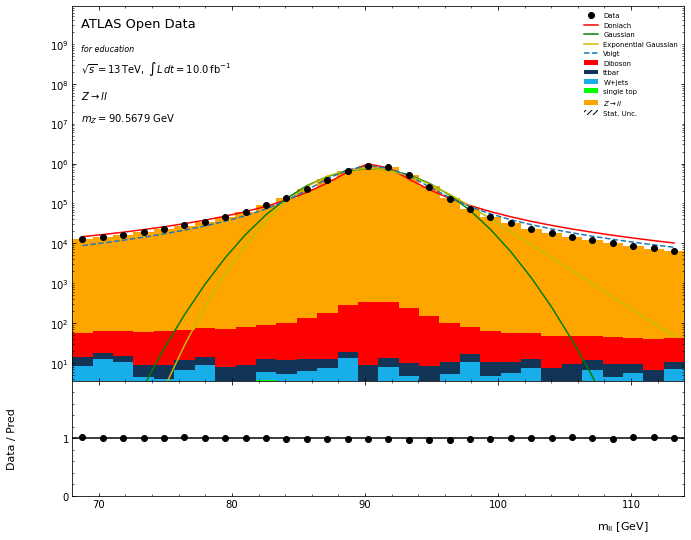

Statistics for the Doniach Model: 


chi^2 = 2.3028685517424514
chi^2/dof = 0.08857186737470966
center = 90.5678642724641
sigma = 2.2802080196698364
Relative Uncertainty of Center = 0.0013563340592615556
Relative Uncertainty of Sigma = 0.05495280945092878


Statistics for the Gaussian Model: 


chi^2 = 99149.90565116609
chi^2/dof = 3672.2187278209663
center = 90.41617601811322
sigma = 3.402945218571574
Relative Uncertainty of Center = 0.002387969477710626
Relative Uncertainty of Sigma = 0.053634739311160105


Statistics for the Exponential Gaussian Model: 


chi^2 = 86237.46708081722
chi^2/dof = 3316.8256569545088
center = 88.60667601626784
sigma = 2.8753524969956787
Relative Uncertainty of Center = 0.006276060563575656
Relative Uncertainty of Sigma = 0.1184960364904571


Statistics for the Voigt Model: 


chi^2 = 1.370470786359577
chi^2/dof = 0.05075817727257693
center = 90.45685707634291
sigma = 1.738141028024721
Relative Uncertainty of Center = 0.000724110190253958
Relative Uncertai

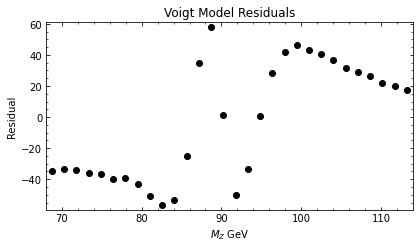

In [23]:
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    make_plots(fraction=i)

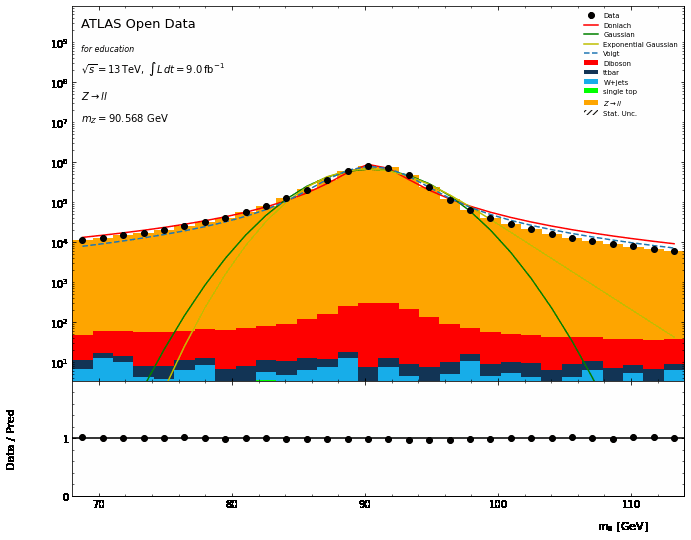

In [22]:
from PIL import Image
import glob

# Create the frames
frames = []
imgs = glob.glob("*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)
from IPython.display import Image as npimg
npimg(filename='png_to_gif.gif')

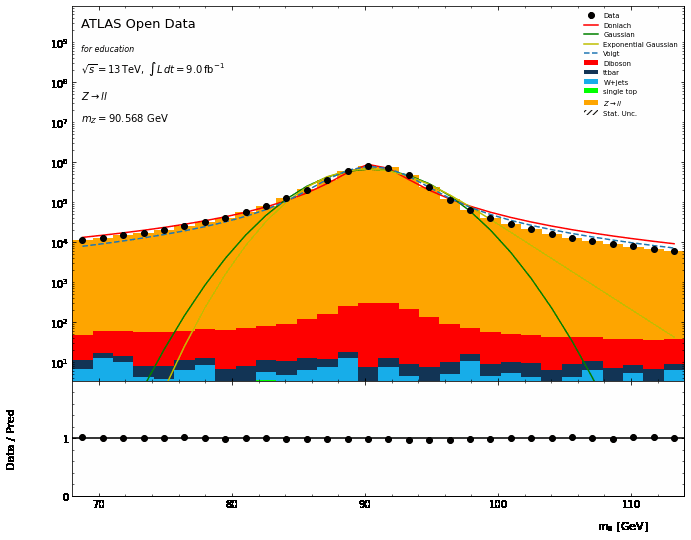

In [18]:
!ls -lh histograms

total 80
-rw-rw-r--@ 1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_0.1.npz
-rw-r--r--  1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_0.2.npz
-rw-r--r--  1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_0.3.npz
-rw-r--r--  1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_0.4.npz
-rw-r--r--  1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_0.5.npz
-rw-r--r--  1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_0.6.npz
-rw-r--r--  1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_0.7.npz
-rw-r--r--  1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_0.8.npz
-rw-r--r--  1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_0.9.npz
-rw-r--r--  1 robinnewhouse  staff   3.3K Mar  4 17:14 mll_hist_1.0.npz
